<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/13-BERT-SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>BERT</h1>

En esta notebook exploraremos el uso de modelos tipo BERT para resolver la tarea de *Análisis de Sentimientos*. Esto lo haremos de dos formas:

1. Haciendo fine-tuning a un modelo BERT.
2. Usando los embeddings generados por BERT como features para un algoritmo de ML.

Usaremos modelos pre-entrenados almacenados en [HuggingFace](https://huggingface.co/).

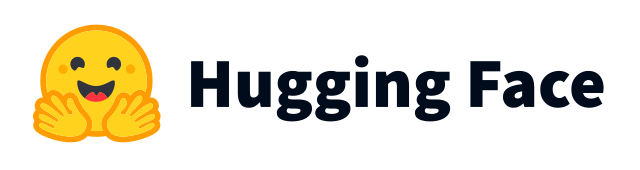

---

*Hugging Face, Inc. es una empresa estadounidense conocida por su biblioteca de transformadores creada para aplicaciones de procesamiento de lenguaje natural y su plataforma que permite a los usuarios compartir [datasets](https://huggingface.co/datasets) y [modelos](https://huggingface.co/models) de aprendizaje automático.  Su campo de acción principal es el NLP, pero también se centra en otras áreas del ML, como la visión de máquina, el aprendizaje por refuerzo y el aprendizaje supervisado.*

---

Regresaremos al dataset de 50K reviews de [IMDB](https://www.imdb.com/). Recordemos los rendimientos que habíamos obtenido:

* **Naive Bayes y ML clásico**. Accuracy: $\sim$ 75-82%.
* **Embeddings de Word2Vec, GloVe, Doc2Vec**. Accuracy: $\sim$ 85-87%.
* **BERT**: Accuracy $\sim$ ❓

# 1. Dataset

Leemos el dataset y hacemos la división en

* Entrenamiento: 30,000
* Validación: 10,000
* Prueba: 10,000

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

imdb_df = pd.read_csv('../../datasets/pln/IMDB.csv')
display(imdb_df)

y = LabelEncoder().fit_transform(imdb_df['sentiment'].values)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(imdb_df['review'].values, y, test_size=0.2, random_state=642, stratify=y)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.25, random_state=473, stratify=y_train)
print(f"Training set size: {len(X_train_raw)}")
print(f"Validation set size: {len(X_val_raw)}")
print(f"Test set size: {len(X_test_raw)}")

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Training set size: 30000
Validation set size: 10000
Test set size: 10000


#2. Limpieza y preprocesamiento

In [2]:
import nltk
from nltk import word_tokenize
import re
from string import punctuation

nltk.download('punkt') # este ya va de salida
nltk.download('punkt_tab')
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to /home/jesusg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jesusg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jesusg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


El preprocesamiento y limpieza tarda alrededor de 2 minutos

In [3]:
X_train_raw = [re.sub(r'\d+', ' ', doc) for doc in X_train_raw]
train_tokenized_docs = [[x for x in word_tokenize(doc) if x not in stopwords and x not in punctuation]
                        for doc in X_train_raw]
train_docs = [' '.join(doc) for doc in train_tokenized_docs]

X_test_raw = [re.sub(r'\d+', ' ', doc) for doc in X_test_raw]
test_tokenized_docs = [[x for x in word_tokenize(doc) if x not in stopwords and x not in punctuation]
                       for doc in X_test_raw]
test_docs = [' '.join(doc) for doc in test_tokenized_docs]

X_val_raw = [re.sub(r'\d+', ' ', doc) for doc in X_val_raw]
val_tokenized_docs = [[x for x in word_tokenize(doc) if x not in stopwords and x not in punctuation]
                      for doc in X_val_raw]
val_docs = [' '.join(doc) for doc in val_tokenized_docs]

Exploremos la distribución de las longitudes de los textos

Average training text length: 140.651
Average test text length: 140.7388
Average validation text length: 140.178


/tmp/ipykernel_29419/4238782235.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


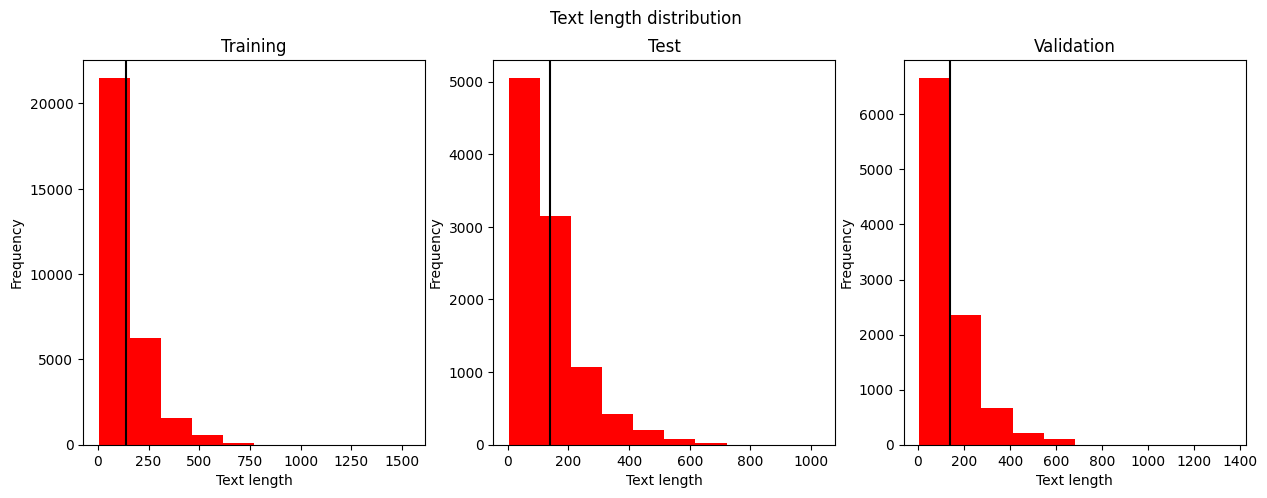

In [4]:
import numpy as np
import matplotlib.pyplot as plt

train_lengths = []
test_lengths = []
val_lengths = []

for doc in train_tokenized_docs:
    train_lengths.append(len(doc))

for doc in test_tokenized_docs:
    test_lengths.append(len(doc))

for doc in val_tokenized_docs:
    val_lengths.append(len(doc))

avg_train_text_length = np.mean(train_lengths)
avg_test_text_length = np.mean(test_lengths)
avg_val_text_length = np.mean(val_lengths)

print(f"Average training text length: {avg_train_text_length}")
print(f"Average test text length: {avg_test_text_length}")
print(f"Average validation text length: {avg_val_text_length}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Text length distribution')
axs[0].hist(train_lengths, color='red')
axs[0].axvline(avg_train_text_length, color='black')
axs[0].set_xlabel('Text length')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Training')
axs[1].hist(test_lengths, color='red')
axs[1].axvline(avg_test_text_length, color='black')
axs[1].set_xlabel('Text length')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Test')
axs[2].hist(val_lengths, color='red')
axs[2].axvline(avg_val_text_length, color='black')
axs[2].set_xlabel('Text length')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Validation')
fig.show()

# 3. Leer el modelo pre-entrenado BERT

Exploraremos dos modelos de BERT:

* [`bert-base-uncased`](https://huggingface.co/google-bert/bert-base-uncased): Es el modelo *pequeño*, tiene 110M de parámetros. Su uso estará comentado.
* [`distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased): Versión más pequeña de BERT, tiene 67M de parámetros.

Dado el tamaño del dataset y lo *grande* del modelo probaremos dos estrategias:

1. Limitaremos el entrenamiento a unos pocos miles de ejemplos, estratificados de acuerdo a sus etiquetas.
2. Mostraremos el comportamiento con el dataset de entrenamiento completo.

In [5]:
num_training_docs = 2000
num_validation_docs = 1000

sample_train_docs, _, sample_train_labels, _ = train_test_split(train_docs, y_train,
                                                                train_size=num_training_docs,
                                                                random_state=777,
                                                                stratify=y_train)

sample_val_docs, _, sample_val_labels, _ = train_test_split(val_docs, y_val,
                                                            train_size=num_validation_docs,
                                                            random_state=777,
                                                            stratify=y_val)

Un modelo de BERT se compone de dos mitades: el tokenizador y el modelo BERT.

## 3.1. Tokenización


Los modelos basados en transformadores tokenizan subpalabras, un enfoque iniciado con `FastText`. El algoritmo se llama wordpiece, fue desarrollado por Google ([más información](https://huggingface.co/learn/nlp-course/chapter6/6)).

Los tokenizadores que usaremos son, respectivamente:

* [BertTokenizer](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer).
* [DistilBertTokenizerFast](https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertTokenizer).

In [6]:
from transformers import BertTokenizer
from transformers import DistilBertTokenizerFast

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Tokenizamos los conjuntos de datos.

**Observación**: El tokenizador no se entrena en el conjunto de datos.

In [7]:
train_encodings = tokenizer(sample_train_docs, truncation=True, padding=True)
val_encodings = tokenizer(sample_val_docs, truncation=True, padding=True)
test_encodings = tokenizer(test_docs, truncation=True, padding=True)

In [8]:
tokenizer.vocab_size

30522

In [9]:
tokenizer.model_max_length, print(len(train_encodings['input_ids'][0]))

512


(512, None)

Exploremos el vocabulario, ya no son palabras solamente, en el sentido usual.

In [10]:
tokenizer.get_vocab()

{'responsibility': 5368,
 'difference': 4489,
 'intern': 25204,
 'speaking': 4092,
 'certainly': 5121,
 '[unused224]': 229,
 '##″': 30067,
 'essence': 11305,
 '##fully': 7699,
 '##lessly': 10895,
 'seat': 2835,
 'scoffed': 26326,
 'oz': 11472,
 'whispered': 3990,
 'almeida': 29555,
 'darker': 9904,
 'image': 3746,
 'trade': 3119,
 'nailed': 26304,
 'healthcare': 9871,
 'focused': 4208,
 'metadata': 27425,
 'residues': 22644,
 '##lick': 25230,
 'oliveira': 24263,
 'like': 2066,
 '##urst': 29402,
 'racecourse': 15948,
 '##อ': 29957,
 'military': 2510,
 'northeastern': 8763,
 '##ulu': 20391,
 '##carbon': 26190,
 'af': 21358,
 'byrne': 14928,
 'deficiency': 18888,
 '|': 1064,
 '[unused246]': 251,
 '##ム': 30251,
 '##☉': 30149,
 'natalia': 21521,
 'mastery': 26364,
 'cooper': 6201,
 'pas': 14674,
 '##eti': 20624,
 'tails': 17448,
 'coincided': 18616,
 '##uing': 25165,
 'das': 8695,
 '##ধ': 29901,
 '[unused801]': 806,
 '##kley': 22315,
 'relying': 18345,
 '##扌': 30385,
 'bois': 19651,
 '##tio

Veamos un ejemplo de tokenización

In [11]:
print(sample_train_docs[0])
for idx in train_encodings['input_ids'][0]:
    print(f"{idx}: {tokenizer.decode(idx)}")


THIS FILM IS LAME LAME LAME It takes lot bring over-exaggeration movie movie stunk house I n't even finished movie yet I stop comment bad movie I 'VE NEVER DONE THAT As consumer spend money film Wait comes cable channel something It 's barely TV worthy I REALLY HATE TRASHING A MOVIE BUT THIS MOVIE IS TRASH Barely porn Should X rating Good plot frontal nudity floats boat HORRIBLE high school level acting Do n't know movie received distribution Must contractual thing Really really like watching good movies n't waste time one From one movie lover another YOU WILL BE MAD AT YOURSELF Let say well 've something like perhaps relate value In case I say watch may take something away seeing something 's happened acted someone else therapeutic value


2024-11-20 21:22:14.114233: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 21:22:14.330359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732162934.428983   29419 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732162934.457646   29419 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 21:22:14.655798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

101: [CLS]
2023: this
2143: film
2003: is
20342: lame
20342: lame
20342: lame
2009: it
3138: takes
2843: lot
3288: bring
2058: over
1011: -
4654: ex
27609: ##agger
3370: ##ation
3185: movie
3185: movie
24646: stu
8950: ##nk
2160: house
1045: i
1050: n
1005: '
1056: t
2130: even
2736: finished
3185: movie
2664: yet
1045: i
2644: stop
7615: comment
2919: bad
3185: movie
1045: i
1005: '
2310: ve
2196: never
2589: done
2008: that
2004: as
7325: consumer
5247: spend
2769: money
2143: film
3524: wait
3310: comes
5830: cable
3149: channel
2242: something
2009: it
1005: '
1055: s
4510: barely
2694: tv
11007: worthy
1045: i
2428: really
5223: hate
11669: trash
2075: ##ing
1037: a
3185: movie
2021: but
2023: this
3185: movie
2003: is
11669: trash
4510: barely
22555: porn
2323: should
1060: x
5790: rating
2204: good
5436: plot
19124: frontal
16371: nu
25469: ##dity
24885: floats
4049: boat
9202: horrible
2152: high
2082: school
2504: level
3772: acting
2079: do
1050: n
1005: '
1056: t
2113: know


## 3.2 Fine-Tuning

Construimos los datasets

In [12]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    sample_train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    sample_val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

I0000 00:00:1732161590.933117   16718 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Exploraremos dos estrategias para hacer el fine-tuning:

* **(1)** Entrenar con todo el conjunto de entrenamiento del dataset y evaluar con todo el conjunto de prueba.
* **(2)** Entrenar con una parte pequeña del conjunto de entrenamiento y evaluar con todo el conjunto de prueba.

Para los entrenamientos usaremos dos maneras:

* **(A)** Usando el módelo BERT como un modelo de Keras, entrenado con el método `fit`. Esta puede usar `Tensorflow` o `Pytorch`.
* **(B)** Usando la API de la libreria `Transformers` de HuggingFace, `Trainer`. Forzosamente usando `Pytorch`.

### (1.A)

In [14]:
import tensorflow as tf

# from transformers import TFBertForSequenceClassification
from transformers import TFDistilBertForSequenceClassification

# model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [16]:
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=3)

# Train the model
history = model.fit(
    train_dataset.batch(8),
    epochs=3,
    batch_size=8,
    validation_data=val_dataset.batch(8),
    # callbacks=[early_stopping_callback]
)

Epoch 1/3


I0000 00:00:1732161646.628121   17326 service.cc:148] XLA service 0x7f857080e940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732161646.628487   17326 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-20 21:00:46.641950: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1732161646.666615   17326 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1732161646.673886   17326 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but s

FailedPreconditionError: Graph execution error:

Detected at node Adam/StatefulPartitionedCall_103 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_16718/2445871575.py", line 4, in <module>

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/transformers/modeling_tf_utils.py", line 1229, in fit

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/transformers/modeling_tf_utils.py", line 1709, in train_step

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/optimizers/optimizer.py", line 623, in minimize

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/optimizers/optimizer.py", line 1309, in apply_gradients

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/optimizers/optimizer.py", line 731, in apply_gradients

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/optimizers/optimizer.py", line 1339, in _internal_apply_gradients

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/optimizers/optimizer.py", line 1431, in _distributed_apply_gradients_fn

  File "/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/tf_keras/src/optimizers/optimizer.py", line 1426, in apply_grad_to_update_var

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node Adam/StatefulPartitionedCall_103}}]] [Op:__inference_train_function_16234]

⚡ Resultados

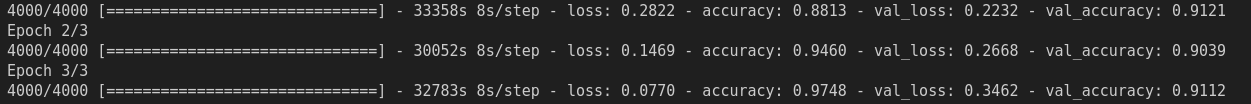

El modelo muestra tendencia de comenzar a subir el rendimiento a la par del entrenamiento

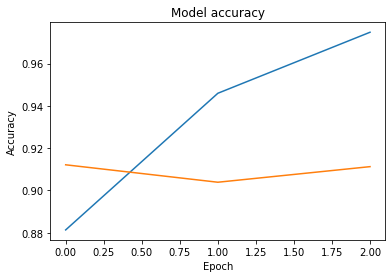

Obtuvimos un $\sim$ 90% de accuracy en el conjunto de prueba. Superando el rendimiento de las métodos anteriores.

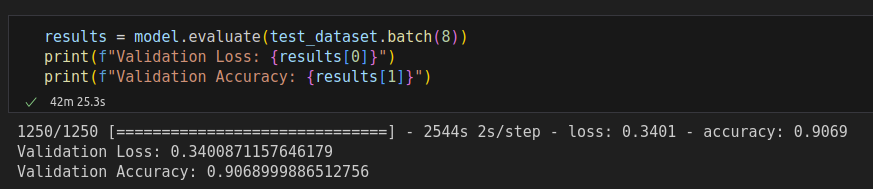

### (2.A)

Obtuvimos rendimientos similares al enfoque usando `doc2vec`

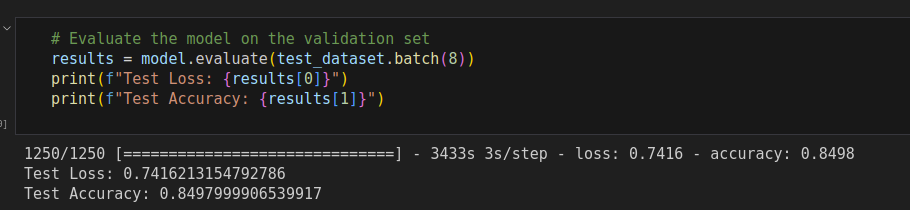

In [ ]:
from transformers import BertTokenizer
from transformers import DistilBertTokenizerFast

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(sample_train_docs, truncation=True, padding=True)
val_encodings = tokenizer(sample_val_docs, truncation=True, padding=True)
test_encodings = tokenizer(test_docs, truncation=True, padding=True)

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    sample_train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    sample_val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [ ]:
from transformers import TFDistilBertForSequenceClassification

# model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history = model.fit(
    train_dataset.batch(8),
    epochs=4,
    batch_size=8,
    validation_data=val_dataset.batch(8),
    # callbacks=[early_stopping_callback]
)

### Finetuning con la clase [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) de transformers

`Trainer` es una API de HuggingFace para hacer fine-tuning a modelos para tareas específicas. Hay dos variantes:

* **Trainer**:
* **TFTrainer**: Obsoleta, ya no se encuentra en la versión más reciente de transformers.

Se requiere que definamos 2 objetos:

* `TrainingArguments`: Especifica los hiperparámetros de entrenamiento. Todas las opciones se pueden encontrar en [docs](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). Por ejemplo, especificamos que queremos evaluar después de cada epoch de entrenamiento, nos gustaría guardar el modelo cada epoch, establecemos la tasa de aprendizaje, el tamaño del lote a utilizar para el entrenamiento/evaluación, para cuántas epochs entrenar, etc.
* `Trainer`: [Docs](https://huggingface.co/transformers/main_classes/trainer.html#id1).


In [12]:
train_df = pd.DataFrame(data={
                        'text': train_docs,
                        'label': y_train
                    })

val_df = pd.DataFrame(data={
                        'text': val_docs,
                        'label': y_val
                    })

test_df = pd.DataFrame(data={
                        'text': test_docs,
                        'label': y_test
                    })

train_df

,text,label
0,Pet Sematary good horror film believe somebody...,1
1,This pretty run mill family move I sure childr...,0
2,Mighty Morphin Power Rangers got worst televis...,0
3,The Kid born retarded It pulls half-dozen dire...,0
4,It amazes production companies sue reproductio...,1
...,...,...
29995,Low-budget memorable would-be shocker instead ...,1
29996,If see movie know see extense video-clip popul...,1
29997,The one thing I really ca n't seem forget movi...,1
29998,I 'm alone admiring first Superman movie film ...,0


In [14]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [16]:
# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [17]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           num_labels=2
                                                           )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments

batch_size = 8
metric_name = 'accuracy'
num_epocas = 1

args = TrainingArguments(
    f"bert-finetuning",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epocas,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    report_to="none"
)

/home/jesusg/anaconda3/envs/nlp-mcd/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
)

/tmp/ipykernel_29419/3226043276.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.305900,0.316083


KeyError: "The `metric_for_best_model` training argument is set to 'eval_accuracy', which is not found in the evaluation metrics. The available evaluation metrics are: ['eval_loss']. Please ensure that the `compute_metrics` function returns a dictionary that includes 'eval_accuracy' or consider changing the `metric_for_best_model` via the TrainingArguments."

In [21]:
eval_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
print(f"Test Evaluation Results: {eval_results}")

Test Evaluation Results: {'eval_loss': 0.3160831928253174}


In [22]:
# Save the entire model as a HDF5 file
model.save_pretrained("BERT_saved_model")

# Optionally, if you also want to save the tokenizer used during training
tokenizer.save_pretrained("BERT_saved_model_tokenizer")

('BERT_saved_model_tokenizer/tokenizer_config.json',
 'BERT_saved_model_tokenizer/special_tokens_map.json',
 'BERT_saved_model_tokenizer/vocab.txt',
 'BERT_saved_model_tokenizer/added_tokens.json',
 'BERT_saved_model_tokenizer/tokenizer.json')

Visualizando la atención:

https://huggingface.co/spaces/exbert-project/exbert

# Embeddings

En este caso usaremos los embeddings generados por un módelo BERT pre-entrenado como features para un algoritmo de ML.

In [25]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [26]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Con esta función obtenemos los embeddings de cada texto

In [29]:
import torch

device = torch.device("cuda")

model.to(device)

def get_cls_embedding(texts, verbose=False):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    if verbose:
        tokenized_length = len([idx for idx in encoded_input['input_ids'][0]
                               if idx != 0])
        print(f'Tokenized length: {tokenized_length}')
    encoded_input = {key: value.to(device) for key, value in encoded_input.items()}
    with torch.no_grad():
        model_output = model(**encoded_input, output_hidden_states=True)
    if verbose:
        print(model_output['hidden_states'][-1].shape)
    cls_embeddings = model_output['hidden_states'][-1][:, 0, :]
    return cls_embeddings.cpu().numpy()

Imprimamos información sobre las formas de las salidas para ilustrar lo que estamos obteniendo:

In [30]:
_ = get_cls_embedding(sample_train_docs[0],verbose=True)

Tokenized length: 149
torch.Size([1, 149, 768])


In [31]:
import numpy as np

train_embeddings = np.zeros((len(sample_train_docs), 768))

for i, text in enumerate(sample_train_docs):
    train_embeddings[i] = get_cls_embedding(text).reshape(-1,)

In [32]:
val_embeddings = np.zeros((len(sample_val_docs), 768))

for i, text in enumerate(sample_val_docs):
    val_embeddings[i] = get_cls_embedding(text).reshape(-1,)

In [33]:
import numpy as np

train_embeddings = np.load('imdb sample train embeddings bert.npy')
val_embeddings = np.load('imdb sample test embeddings bert.npy')
train_labels = np.load('imdb sample train labels.npy')
val_labels = np.load('imdb sample test labels.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'imdb sample train embeddings bert.npy'

In [39]:
len(val_embeddings)

1000

In [35]:
train_labels = train_df['label'].values
val_labels = val_df['label'].values

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clfs = [
    RandomForestClassifier(),
    SVC(C=2),
    LogisticRegression(max_iter=10000)
]

names = [
    'Random Forest',
    'SVC',
    'Logistic Regression'
]

for name,clf in zip(names,clfs):
    pl = make_pipeline(StandardScaler(), clf)
    pl.fit(train_embeddings, train_labels)
    print(name, pl.score(val_embeddings, val_labels))

ValueError: Found input variables with inconsistent numbers of samples: [2000, 30000]

# 🔴 Tarea:

Usando otro modelo tipo BERT (DeBERTa, ALBERT, ELECTRA, etc), realiza la tarea de clasificación en el dataset de reviews de turismo en español.

Aquí hay dos desafios que explorar:

1. ¿Los modelos anteriores se pueden usar en español?
2. Buscar un modelo específico en español.

Para esta tarea, realiza una división *train/test* similar a la hecha en la práctica anterior con este dataset.

Para realizar el entrenamiento puedes usar la estrategia (1.A) o la clase `Trainer`.

## Utilizando un modelo de tipo BERT "normal"

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk import word_tokenize
import re
from string import punctuation

nltk.download('punkt') # este ya va de salida
nltk.download('punkt_tab')
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package punkt to /home/jesusg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jesusg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jesusg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
train_df = pd.read_csv('../../datasets/pln/resenas/train.csv', index_col=0)
train_df.head()

,Title,Opinion,Place,Gender,Age,Country,Date,Label
0,"""No es para recomendarse""","""Las famosas momias de Guanajuato. El museo en...",Museo de las Momias,Male,48,México,02/07/2013,0
1,"""Es un mercado tradicional, no es nada del otr...","""Allí puedes encontrar comida o souvenirs. Es ...",Mercado Hidalgo,Male,52,México,06/09/2016,0
2,"""No visitar""","""Es tardado entrar al museo, una vez dentro no...",Museo de las Momias,Male,42,México,25/12/2017,0
3,"""No le veo atractivo. A ver semejantes cacharros""","""Entiendo que a muchos les cautive o llamé la ...",Museo de las Momias,Female,24,México,14/08/2013,0
4,"""Nada fuera de lo común""","""La fruta y verdura son poco frescos, al igual...",Mercado Hidalgo,Female,19,México,01/08/2017,0


In [68]:
test_df = pd.read_csv('../../datasets/pln/resenas/test_features.csv',index_col=0)
test_df.head()

,Title,Opinion,Place,Gender,Age,Country,Date
0,"""No coman ahí""","""Creo que es muy insalubre, hay basura por tod...",Mercado Hidalgo,Female,61,México,15/01/2013
1,"""Romántico""","""Es un callejón común donde todos toman fotos ...",Callejón del Beso,Female,42,Uruguay,22/06/2015
2,Muy descuidado,"Cierto, es un mercado, pero no por eso hay que...",Mercado Hidalgo,Male,-1,México,2019
3,"""Impresionante""","""El acabado del altar es sumamente bonito, aun...",Basilica Colegiata,Male,26,México,08/10/2013
4,"""No es lo máximo""","""De todo lo hermoso que tiene Guanajuato esto ...",Basilica Colegiata,Female,54,México,10/01/2012


In [104]:
def process_training_df(df):
    df.drop(columns=['Place','Gender','Age','Country','Date'])
    df['text'] = df['Title'].str.replace(r'"', ' ', regex=True) + ' ' + df['Opinion'].str.replace(r'"', ' ', regex=True)
    df['text'] = df['text'].str.replace(r'\d+',' ', regex=True)
    df['text'] = df['text'].str.replace(r'[¿¡]',' ', regex=True)
    df
    if 'Label' in df.columns:
        df = df[['text','Label']]
        return df
    else:
        df = df[['text']]
        return df

In [105]:
train_df_processed = process_training_df(train_df)
train_df_processed.head()

,text,Label
0,No es para recomendarse Las famosas momias ...,0
1,"Es un mercado tradicional, no es nada del otr...",0
2,"No visitar Es tardado entrar al museo, una ...",0
3,No le veo atractivo. A ver semejantes cacharr...,0
4,Nada fuera de lo común La fruta y verdura s...,0


In [106]:
test_df_processed = process_training_df(test_df)
test_df_processed.head()

,text
0,"No coman ahí Creo que es muy insalubre, hay..."
1,Romántico Es un callejón común donde todos ...
2,"Muy descuidado Cierto, es un mercado, pero no ..."
3,Impresionante El acabado del altar es sumam...
4,No es lo máximo De todo lo hermoso que tien...


In [107]:
X_train, X_val, y_train, y_val = train_test_split(train_df_processed['text'], train_df_processed['Label'], test_size=0.25, random_state=42)

In [108]:
y_test = np.load('../../datasets/pln/resenas/test_labels.npy')

In [109]:
def tokenize_text(text):
    tokens = word_tokenize(text)  # Tokenize the text
    filtered_tokens = [
        token.lower() for token in tokens 
        if token.lower() not in stopwords and token not in punctuation
    ]
    return filtered_tokens

In [129]:
X_train_tokenized = X_train.astype(str).apply(tokenize_text).apply(' '.join)
X_val_tokenized = X_val.apply(tokenize_text).apply(' '.join)
X_test_tokenized = test_df_processed['text'].astype(str).apply(tokenize_text).apply(' '.join)

In [130]:
X_train_tokenized

2408    creepy elemento bueno atracción turística apro...
1213    excelente edificio ubicación bonita construcci...
1200    vista espectacular si vas ciudad guanajuato qu...
2018    linda iglesia iglesia tradicional bella varias...
2372    deslumbrante puedes dejar visitarlo representa...
                              ...                        
3444    primer viaje juntos lugar súper bonito ir toma...
466     bien mundo suficientes momias guía melodramati...
3092    hermosa hermosa plaza céntrica mariachis bares...
3772    pípila funicular cantoya contemplé mayor parte...
860     lugar histórico impresionante mirar lugar pued...
Name: text, Length: 3312, dtype: object

Average training text length: 174.28291062801932
Average test text length: 178.5
Average validation text length: 176.2398190045249


/tmp/ipykernel_29419/2207889412.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


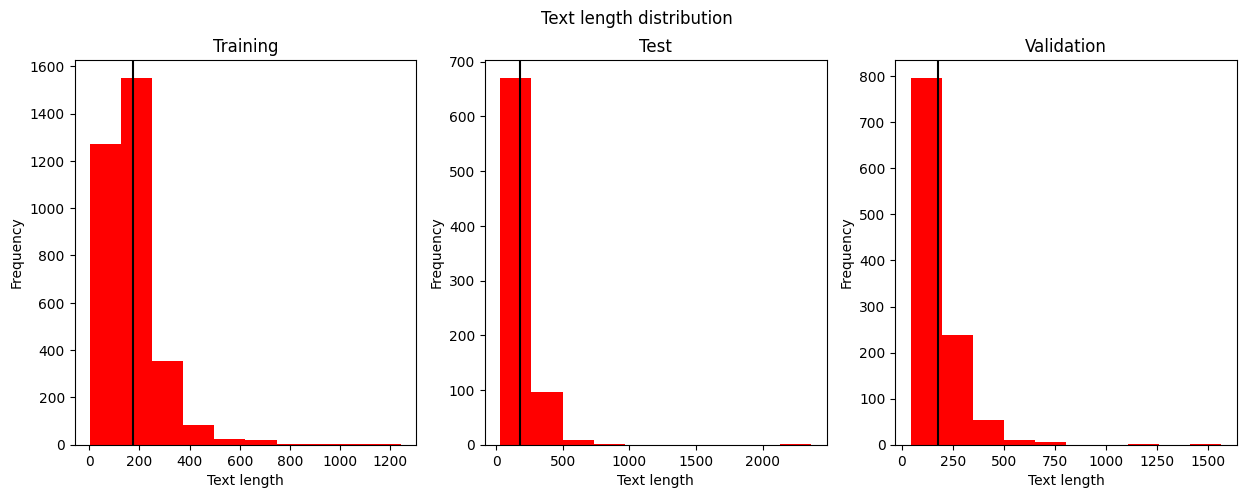

In [131]:
train_lengths = []
test_lengths = []
val_lengths = []

for doc in X_train_tokenized:
    train_lengths.append(len(doc))

for doc in X_test_tokenized:
    test_lengths.append(len(doc))

for doc in X_val_tokenized:
    val_lengths.append(len(doc))

avg_train_text_length = np.mean(train_lengths)
avg_test_text_length = np.mean(test_lengths)
avg_val_text_length = np.mean(val_lengths)

print(f"Average training text length: {avg_train_text_length}")
print(f"Average test text length: {avg_test_text_length}")
print(f"Average validation text length: {avg_val_text_length}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Text length distribution')
axs[0].hist(train_lengths, color='red')
axs[0].axvline(avg_train_text_length, color='black')
axs[0].set_xlabel('Text length')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Training')
axs[1].hist(test_lengths, color='red')
axs[1].axvline(avg_test_text_length, color='black')
axs[1].set_xlabel('Text length')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Test')
axs[2].hist(val_lengths, color='red')
axs[2].axvline(avg_val_text_length, color='black')
axs[2].set_xlabel('Text length')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Validation')
fig.show()

#### Cargando el modelo `ALBERT` y su tokenizador

In [132]:
from transformers import AlbertTokenizerFast

tokenizer = AlbertTokenizerFast.from_pretrained('albert/albert-base-v2')

In [133]:
train_encodings = tokenizer(list(X_train_tokenized), truncation=True, padding=True)
val_encodings = tokenizer(list(X_val_tokenized), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test_tokenized), truncation=True, padding=True)

In [134]:
print(X_train_tokenized[0])
for idx in train_encodings['input_ids'][0]:
    print(f"{idx}: {tokenizer.decode(idx)}")

recomendarse famosas momias guanajuato museo horrible exhiben sino exhiben abuelo contó hace años visitar momias entrar panteón pasear tumbas darle propina sepulturero levantaba pesada aldaba después bajar escalera caracol lúgubre cripta ahí cuerpos alineados tras ambos lados estrecho pasillo pasar cristales medio suena escalofriante auténtico ... debieron haber dejado así limitar número personas pudieran visitar diariamente quizás unas haber cobrado bueno ve museo buena fuente ingresos erario bella ciudad recomiendo visitarlo sólo si visitaron todas demás atracciones bellezas ofrece guanajuato si queda tiempo pues bien
2: [CLS]
20251: creepy
4520: element
111: o
3183: bu
8625: eno
35: at
5797: rac
10934: cion
6205: tur
3771: istic
58: a
21: a
2740: pro
195: ve
3606: chan
349: car
5183: act
106: er
3771: istic
58: a
7197: tier
525: ra
29545: conserva
3141: cu
106: er
12551: pos
1331: da
13: 
5970: mie
537: do
13: 
26830: princip
1963: io
15178: gust
111: o
3: [SEP]
0: <pad>
0: <pad>
0:

#### Fine tuning con `Trainer`

In [135]:
from datasets import Dataset

train_df = pd.DataFrame(data={
                        'text': X_train_tokenized,
                        'label': y_train
                    })

val_df = pd.DataFrame(data={
                        'text': X_val_tokenized,
                        'label': y_val
                    })

test_df = pd.DataFrame(data={
                        'text': X_test_tokenized,
                        'label': y_test
                    })

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [136]:
# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

Map:   0%|          | 0/3312 [00:00<?, ? examples/s]

Map:   0%|          | 0/1105 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

In [139]:
from transformers import AlbertForSequenceClassification

model = AlbertForSequenceClassification.from_pretrained('albert/albert-base-v2')

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [140]:
from transformers import TrainingArguments
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "0,1" for multiple GPUs

batch_size = 8
num_epocas = 1

args = TrainingArguments(
    f"bert-finetuning",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epocas,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

In [141]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
)

/tmp/ipykernel_29419/3226043276.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [142]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.477028


TrainOutput(global_step=414, training_loss=0.47355637112677385, metrics={'train_runtime': 46.094, 'train_samples_per_second': 71.853, 'train_steps_per_second': 8.982, 'total_flos': 19787628257280.0, 'train_loss': 0.47355637112677385, 'epoch': 1.0})

In [143]:
eval_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
print(f"Test Evaluation Results: {eval_results}")

Test Evaluation Results: {'eval_loss': 0.5799967646598816, 'eval_runtime': 3.1881, 'eval_samples_per_second': 244.656, 'eval_steps_per_second': 30.739, 'epoch': 1.0}


## Utilizando un modelo en español

En este caso, estaré utilizando el modelo [BETO](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased)

In [145]:
from transformers import BertForSequenceClassification, BertTokenizer
# create the tokenizer and the model

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=False)
model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [146]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format to PyTorch tensors
tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

Map:   0%|          | 0/3312 [00:00<?, ? examples/s]

Map:   0%|          | 0/1105 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

In [151]:
print(X_train_tokenized[1])
for idx in tokenized_train_dataset['input_ids'][1]:
    print(f"{idx}: {tokenizer.decode(idx)}")

mercado tradicional mundo allí puedes encontrar comida souvenirs antigua bodega funciona ahora mercado mejor ir lugar diferente guanajuato pues oferta gastronómica bien variada
4: [CLS]
7730: excelente
4637: edificio
9599: ubicación
9412: bonita
12244: construc
1426: ##cion
5930: escal
1402: ##ina
1095: ##ta
12554: famosa
9412: bonita
7730: excelente
17512: ubica
1426: ##cion
6617: universidad
1594: buen
4027: ambiente
4104: alrededor
1947: asi
2264: seguridad
14029: publica
19644: policia
24193: estudian
1419: ##tado
4104: alrededor
5: [SEP]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1: [PAD]
1

In [147]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "0,1" for multiple GPUs

batch_size = 8
num_epocas = 1

args = TrainingArguments(
    f"bert-finetuning",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epocas,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

In [148]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
)

/tmp/ipykernel_29419/1101588060.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [152]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.348266


TrainOutput(global_step=414, training_loss=0.3755202731072615, metrics={'train_runtime': 59.2121, 'train_samples_per_second': 55.934, 'train_steps_per_second': 6.992, 'total_flos': 217855953838080.0, 'train_loss': 0.3755202731072615, 'epoch': 1.0})

In [153]:
eval_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
print(f"Test Evaluation Results: {eval_results}")

Test Evaluation Results: {'eval_loss': 0.28717589378356934, 'eval_runtime': 2.7922, 'eval_samples_per_second': 279.352, 'eval_steps_per_second': 35.098, 'epoch': 1.0}
